In [1]:

import json
import geopandas as gpd

with open('proj4_params.json', 'r') as f:
    json_data = json.load(f)
    
points = gpd.read_file('proj4_points.geojson')
points = points.to_crs(epsg=2180)
print(points.sindex.valid_query_predicates)

{None, 'touches', 'covered_by', 'crosses', 'contains_properly', 'intersects', 'covers', 'within', 'contains', 'overlaps'}


In [2]:
points_with_buffer = points.buffer(100)
points_with_buffer = gpd.GeoDataFrame(geometry=points_with_buffer, crs=points.crs)
df_joined = gpd.sjoin(points, points_with_buffer, how='inner', predicate='intersects')

In [3]:
lamp_counts = df_joined[json_data['id_column']].value_counts().reset_index()
lamp_counts.columns = [json_data['id_column'], 'count']
lamp_counts = lamp_counts.sort_values(by=json_data['id_column'], ascending=True)
lamp_counts.to_csv('proj4_ex01_counts.csv', index=False)
print(lamp_counts)

      lamp_id  count
2547     5907     16
2561     5908     16
2316     5909     17
1733     5910     20
3468     5911      9
...       ...    ...
2635     9644     16
2640     9645     16
2725     9646     15
3283     9647     12
2001     9648     19

[3742 rows x 2 columns]


In [4]:
import shapely
points_copy = points.copy()
points_copy = points_copy.to_crs(epsg=4326)
points_copy.geometry = shapely.set_precision(points_copy.geometry, grid_size=0.0000001)
points_copy['lat'] = points_copy['geometry'].apply(lambda p: p.y)
points_copy['lon'] = points_copy['geometry'].apply(lambda p: p.x)
extracted_data = points_copy[[json_data['id_column'], 'lat', 'lon']]
print(extracted_data)
extracted_data.to_csv('proj4_ex01_coords.csv', index=False)

      lamp_id        lat        lon
0        5907  50.074043  19.899135
1        5908  50.075053  19.891393
2        5909  50.073055  19.898210
3        5910  50.073520  19.888718
4        5911  50.073280  19.891677
...       ...        ...        ...
3737     9644  50.073446  19.934272
3738     9645  50.070489  19.935150
3739     9646  50.070320  19.935347
3740     9647  50.070155  19.935541
3741     9648  50.067359  19.934254

[3742 rows x 3 columns]


In [5]:
import pyrosm
from shapely.ops import linemerge
fp = pyrosm.get_data(json_data['city'])
print(fp)
osm = pyrosm.OSM(fp)
gdf_driving = osm.get_network(network_type="driving")
gdf_driving = gdf_driving[gdf_driving['highway'] == "tertiary"].copy()
gdf_driving.loc[:, 'geometry'] = gdf_driving['geometry'].apply(lambda geom: linemerge(geom))
#print(gdf_driving)

C:\Users\wiech\AppData\Local\Temp\pyrosm\Cracow.osm.pbf


C:\Users\wiech\PycharmProjects\dataEngineering\.venv\Lib\site-packages\pyrosm\networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


In [6]:
structured_gdf = gdf_driving[['id', 'name', 'geometry']].copy()
structured_gdf.rename(columns={'id': 'osm_id'}, inplace=True)
structured_gdf.head(50)
print(structured_gdf)
structured_gdf.to_file('proj4_ex02_roads.geojson', driver='GeoJSON')

           osm_id                      name  \
1         2954556       Stefana Żeromskiego   
17        5095912                 Borkowska   
20        5095978             Józefa Dietla   
25        6230457    Rondo Stanisława Barei   
31        7953786              Aleja 3 Maja   
...           ...                       ...   
72698  1268638329            Leonida Teligi   
73052  1272158332  Mieczysławy Ćwiklińskiej   
73053  1272158333  Mieczysławy Ćwiklińskiej   
73054  1272158365  Mieczysławy Ćwiklińskiej   
73093  1272734950                  Zdrojowa   

                                                geometry  
1      LINESTRING (20.03607 50.07940, 20.03613 50.079...  
17     LINESTRING (19.90506 50.00710, 19.90516 50.007...  
20     LINESTRING (19.93562 50.04996, 19.93579 50.050...  
25     LINESTRING (19.97368 50.08862, 19.97375 50.088...  
31     LINESTRING (19.92447 50.05924, 19.92434 50.059...  
...                                                  ...  
72698  LINESTRING (20.

In [7]:
points_copy2 = points.copy()
gdf_driving_copy = gdf_driving.copy()
gdf_driving_copy = gdf_driving_copy.to_crs(points.crs)
gdf_driving_buffered = gdf_driving_copy.buffer(50, cap_style=2)
points_copy2 = points_copy2.to_crs(points.crs)
road_lamp_joined = gpd.sjoin(gdf_driving_copy.set_geometry(gdf_driving_buffered), points_copy2)
road_lamp_joined = road_lamp_joined.groupby('name').size().reset_index(name='point_count')
lamp_filtered = road_lamp_joined[road_lamp_joined['point_count'] > 0]
lamp_filtered = lamp_filtered.groupby('name')['point_count'].sum().reset_index()
lamp_filtered.columns = ['name', 'point_count']
lamp_filtered.head(50)
lamp_filtered.to_csv('proj4_ex03_streets_points.csv', index=False)

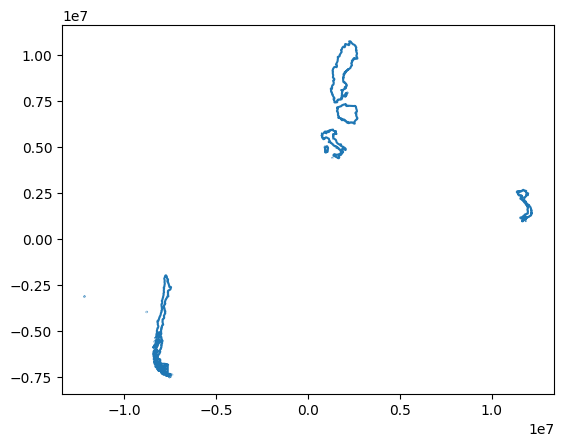

In [8]:
countries = gpd.read_file('proj4_countries.geojson')
countries = countries.to_crs(epsg=3857)
countries['geometry'] = countries['geometry'].boundary
countries.plot()
countries.to_pickle('proj4_ex04_gdf.pkl')

In [9]:
import matplotlib.pyplot as plt
import contextily as ctx

for index, country_row in countries.iterrows():
    country_name = country_row['name'].lower()
    country = countries[countries['name'].str.lower() == country_name]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    country.plot(ax=ax, color='blue', linewidth=2)
        
    ctx.add_basemap(ax, crs=country.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    plt.savefig(f"proj4_ex04_{country_name}.png", bbox_inches='tight')
    plt.close()